In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

In [2]:
import options_wizard as ow

stocks = [
    "AAPL", "MSFT", "NVDA", "GOOG", "GOOGL",
    #"AMZN", "FB", "AVGO", "TSLA", "PEP",
    #"COST", "NFLX", "ADBE", "CSCO", "AMD",
    #"INTC", "LIN", "TXN", "QCOM", "AMAT"
]
for stock in stocks.copy():
    if stock not in available_ticks:
        print(f"Removing {stock} from universe - data not available")
        stocks.remove(stock)

universe = ow.Universe(stocks)
data_manager = ow.DataManager(universe, load_lazy=True)

In [3]:
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('get_underlying')
ow.Transformer(data_manager)('flag_chain_gaps', drop_on_gap = True)
ow.Transformer(data_manager)('scale_by_splits')
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('flag_stale_options', volume_threshold=0)
ow.Transformer(data_manager)('drop_contract', drop = 'c')
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', test_size=0.45, drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')


In [4]:
ow.Features(data_manager)('iv_rv_ratio')
ow.Features(data_manager)('term_structure_slope', near_expiry_days=10, far_expiry_days=30)
ow.Features(data_manager)('mac_vol', lookback_short=5, lookback_long=15)
ow.Features(data_manager)('days_to_earnings')
ow.Features(data_manager)('days_since_earnings')

In [5]:
ow.Strategy(data_manager)(
    'ratio_spread',
    entry_ttm=90,
    ttm_tol=30,
    delta_ntm=0.4,  # selling
    delta_otm=0.15, # buying three of these
    otm_ratio=3,
    delta_tol=0.05,
    call_put="p",
    hold_period=30,
    long='otm',
    overlap_window = 5,
)

In [ ]:
ow.Features(data_manager)('compute_pnl')
data_manager.execute_pipeline(retain_data=True, save_data=False, n_workers=6)

Analysis crashed for MSFT, reattempting, reason: Unable to allocate 489. MiB for an array with shape (12, 5346552) and data type float64
Analysis crashed for AAPL, reattempting, reason: Unable to allocate 611. MiB for an array with shape (12, 6677494) and data type float64


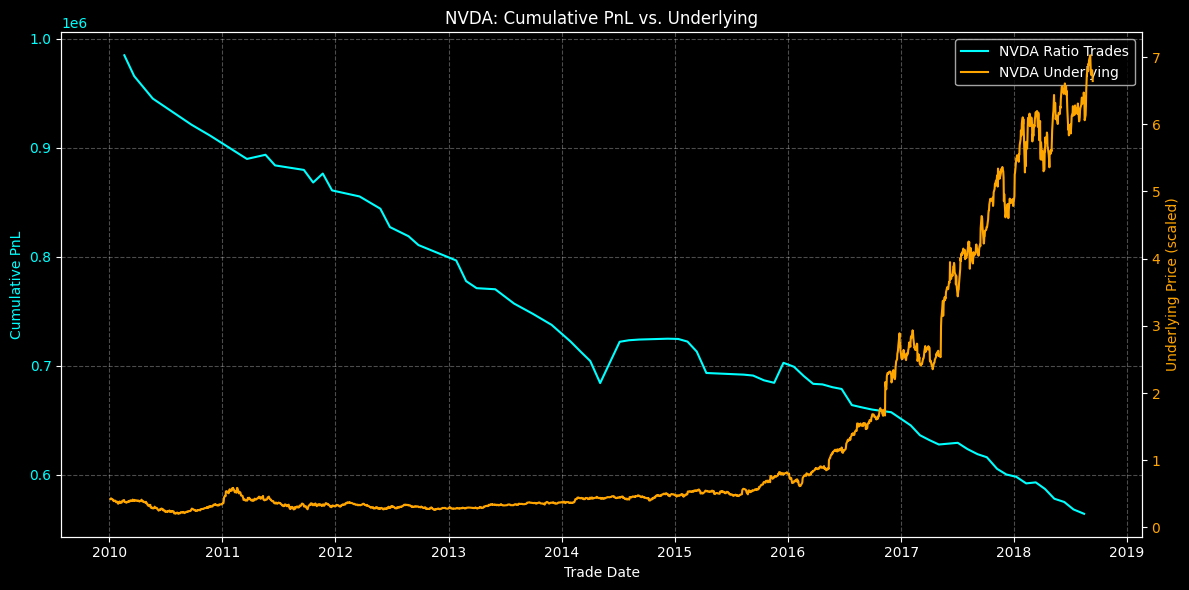

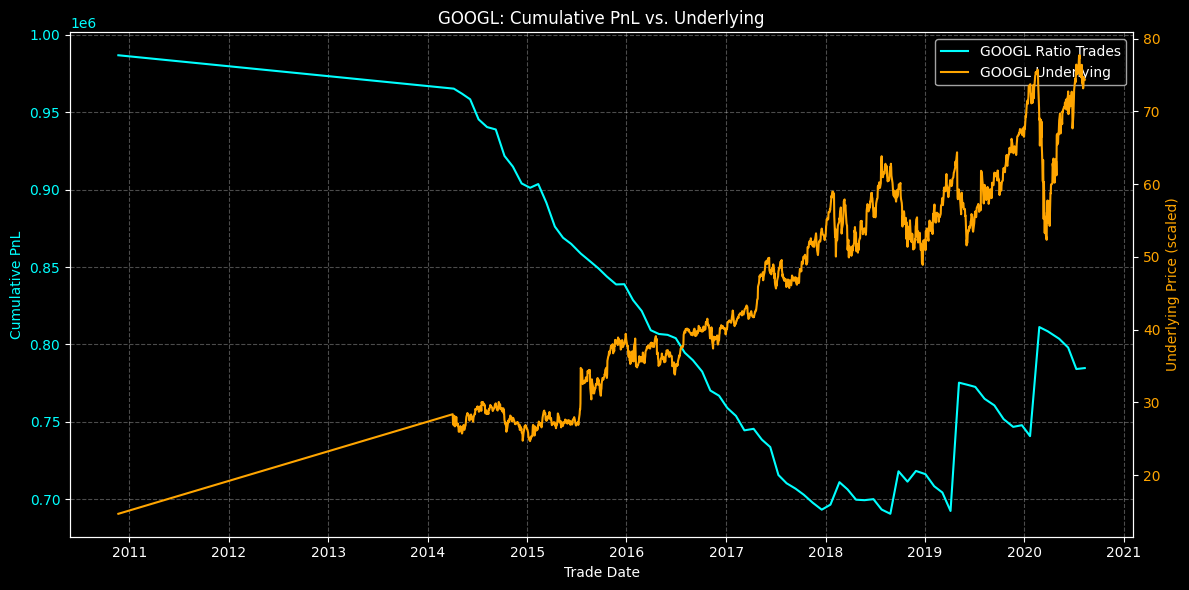

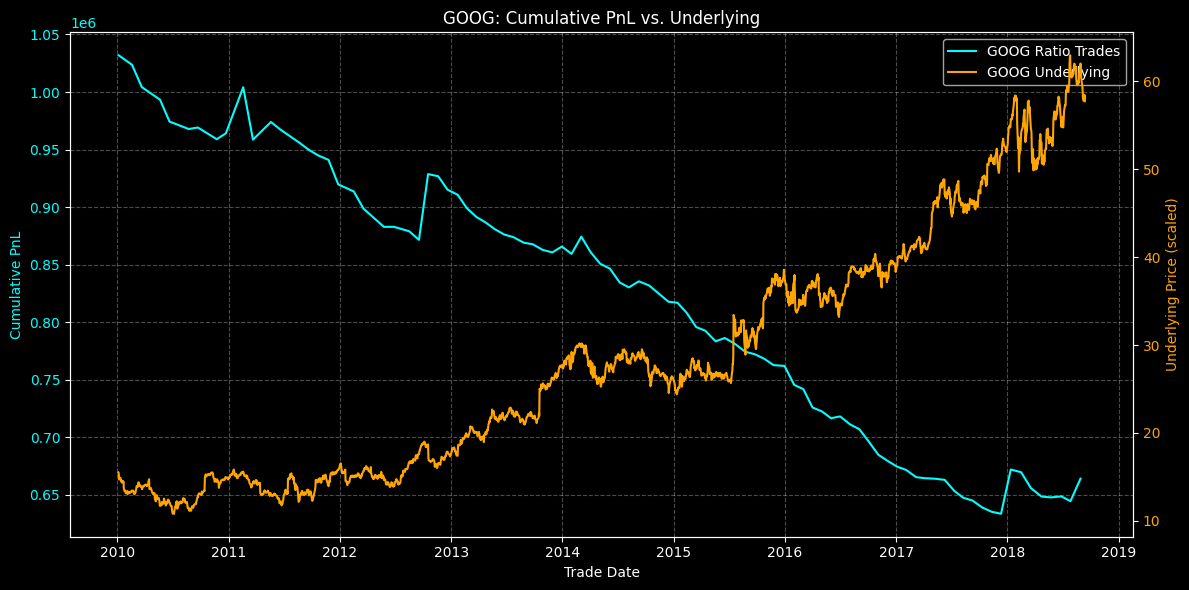

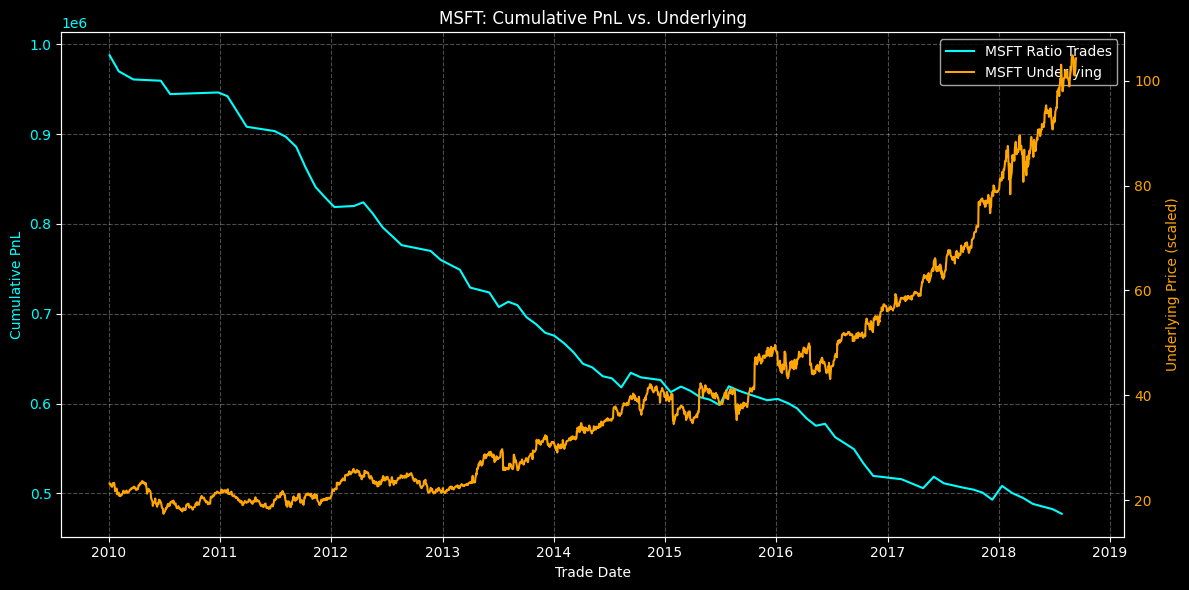

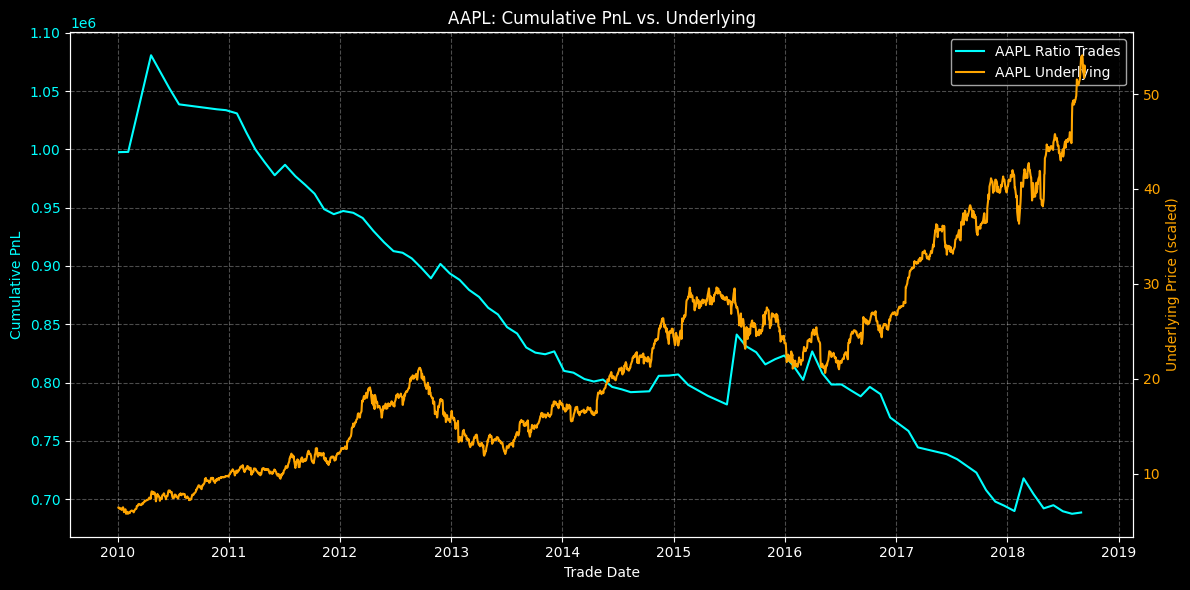

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# Assume data_manager.outputs and data_manager.data are defined
outputs = data_manager.outputs
data = data_manager.data

# Iterate through each ticker independently
for ticker, df in outputs.items():
    # Sort by date
    df = df.sort_index().dropna(subset=['equity'])
    df_data = data[ticker]

    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot equity on left axis
    ax1.plot(df.index, df['equity'], color='cyan', label=f"{ticker} Ratio Trades")
    ax1.set_xlabel("Trade Date")
    ax1.set_ylabel("Cumulative PnL", color='cyan')
    ax1.tick_params(axis='y', labelcolor='cyan')

    # Create right axis for underlying
    ax2 = ax1.twinx()
    df_data['underlying_close'] = (
        df_data['underlying_close'] 
    )
    ax2.plot(
        df_data.index.get_level_values('trade_date_idx'),
        df_data['underlying_close'],
        color='orange',
        label=f"{ticker} Underlying"
    )
    ax2.set_ylabel("Underlying Price", color='orange') 
    ax2.tick_params(axis='y', labelcolor='orange')

    # Title, grid, and legend
    plt.title(f"{ticker}: Cumulative PnL vs. Underlying")
    ax1.grid(True, which='both', linestyle='--', alpha=0.3)

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='best')

    plt.tight_layout()
    plt.show()
